In [1]:
import random
#import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import csv
from pgmpy.readwrite import BIFReader
import time
from itertools import combinations
import statistics
import bnlearn as bn
from pgmpy.metrics import structure_score
from pgmpy.models import BayesianNetwork
import gc
from utils import *
from ga_operators import *
from loaders import *
import matplotlib.pyplot as plt

In [2]:
asia = load_asia_data()
nodes = asia.columns

In [3]:
asia.head()

,S,L,A,T,E,X,B,D
0,1,1,0,0,1,1,1,1
1,0,0,0,0,0,1,1,1
2,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,1,1
4,1,0,0,0,0,0,1,0


In [4]:
gt_adj, node2idx, idx2node = load_gt_adj_asia()

In [5]:
node2idx

{'S': 0, 'L': 1, 'A': 2, 'T': 3, 'E': 4, 'X': 5, 'B': 6, 'D': 7}

In [6]:
gt_adj

array([[0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [7]:
scores = [10,3,5,1,100,8,20,15]
rank = np.argsort(scores)
best_n = rank[:4]
best_n

array([3, 1, 2, 5])

9


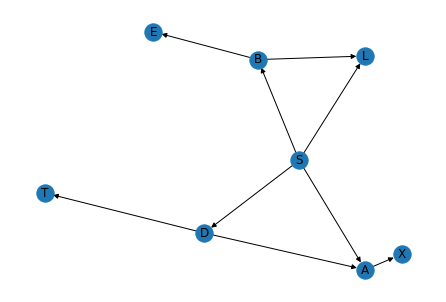

11


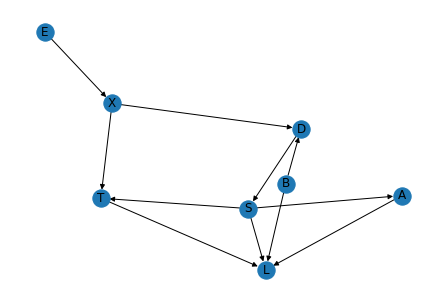

9


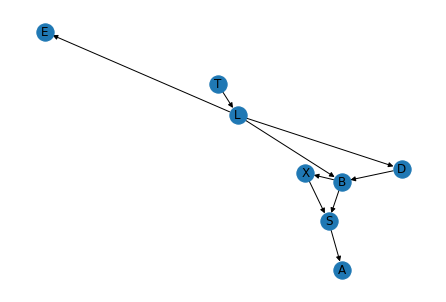

16


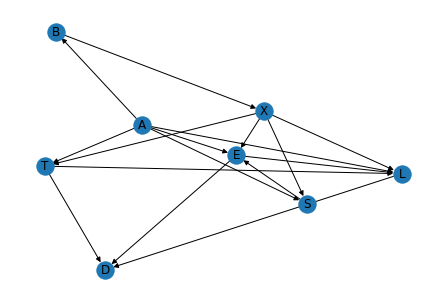

9


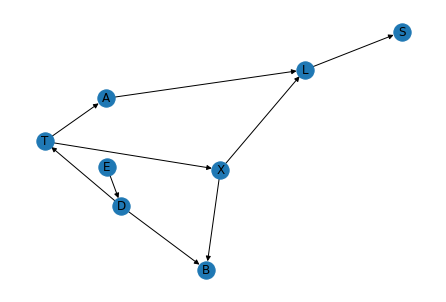

8


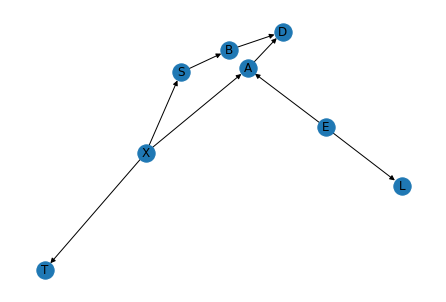

15


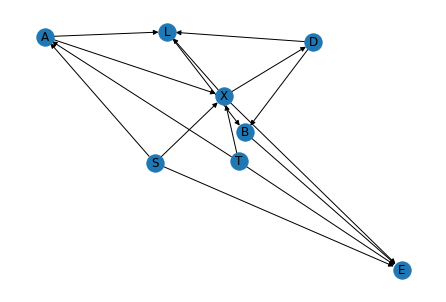

16


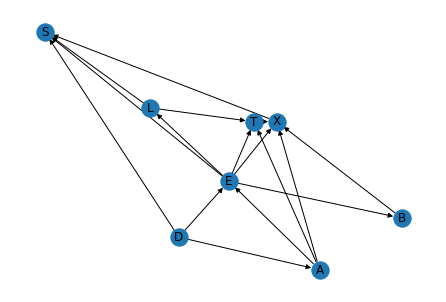

9


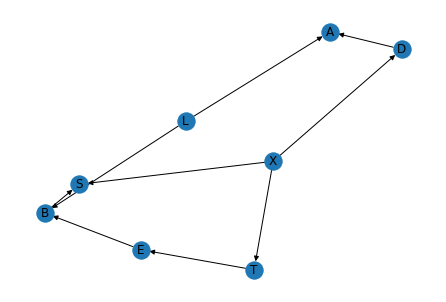

8


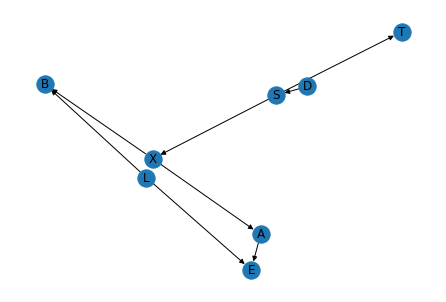

9


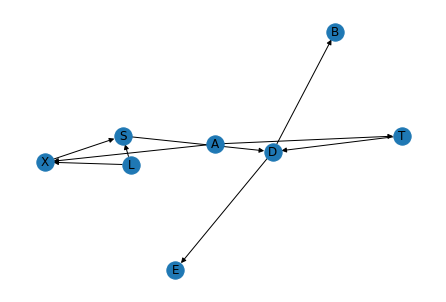

20


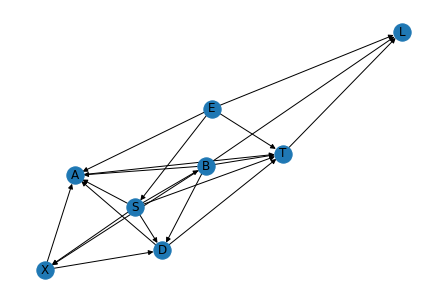

10


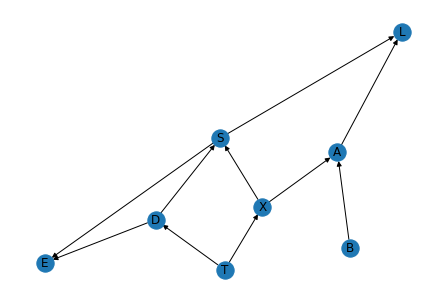

13


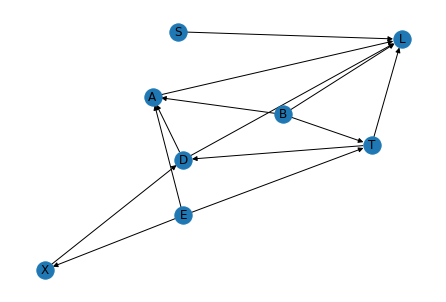

10


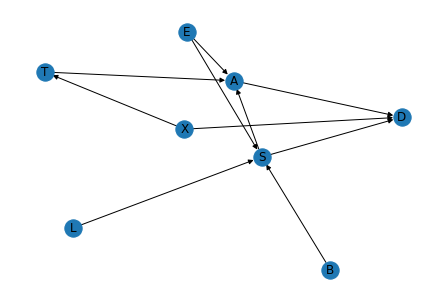

8


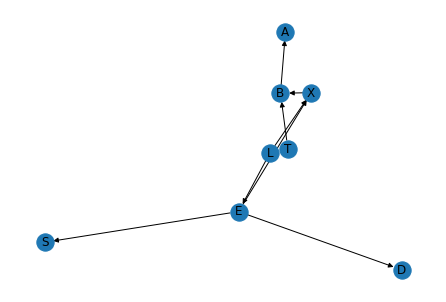

16


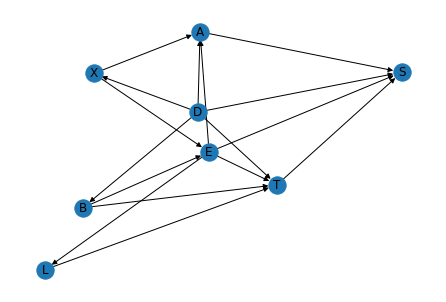

14


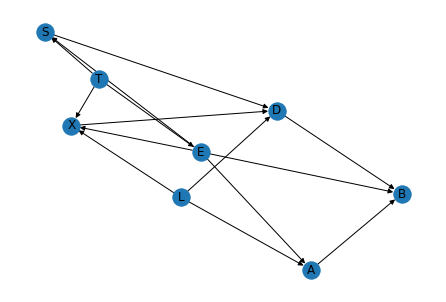

13


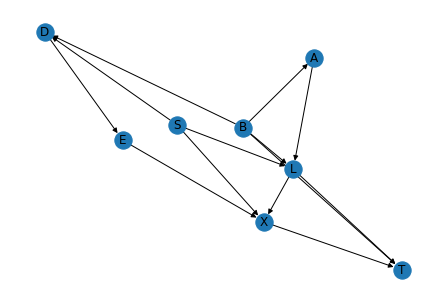

8


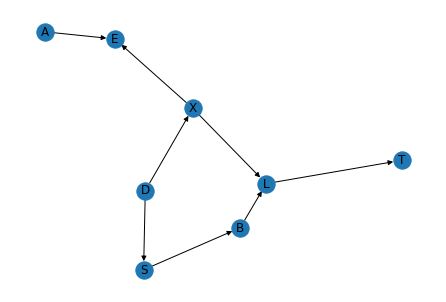

In [10]:
pop = create_population(20, nodes, asia, feasible_only=True)

# create a figure for each individual
for ind in pop:
    digraph = ind.individual_to_digraph()
    print(digraph.number_of_edges())
    # create a new figure
    plt.figure()
    # plot the DAG
    nx.draw(digraph, with_labels=True, arrows=True)
    # show the figure
    plt.show()


In [12]:
def select_best(population, n, data):
    '''
    Select the n best individuals from a population.

    Parameters:
    -----------
    population : list
        List containing the population of DAGs.
    n : int
        Number of individuals to be selected.
    score_function : function
        Function used to compute the score of each individual.
    data : pandas.DataFrame
        Dataset used to compute the score.
    
    Returns:
    --------
    list
        List containing the selected individuals.
    '''
    # Select best individuals
    scores = [i.compute_bic() for i in population]
    rank = np.argsort(scores)
    best_n = rank[:n]
    return list(population[i] for i in best_n)

def select_parents_by_rank(population, num_parents, data):
    '''
    Select parents from a population using rank-based selection.

    Parameters:
    -----------
    population : list
        List containing the population of DAGs.
    num_parents : int
        Number of parents to be selected.
    data : pandas.DataFrame
        Dataset used to compute the score.
    
    Returns:
    --------
    list
        List containing the selected parents.
    '''
    # Rank population
    population = select_best(population, len(population), BIC, data)
    # Compute rank probabilities
    rank_probs = [1/(i+1) for i in range(len(population))]
    rank_probs = [p/sum(rank_probs) for p in rank_probs]
    # Select parents
    parents = random.choices(population, weights=rank_probs, k=num_parents)
    return parents

In [13]:
parents = select_parents_by_rank(pop, 5, asia)

AttributeError: 'Individual' object has no attribute 'is_directed'